<a href="https://colab.research.google.com/github/duke023456/li-mu-deep-learing/blob/main/%E2%80%9Cautograd_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 自动求导
:label:`sec_autograd`

正如我们在 :numref:`sec_calculus` 中所说的那样，求导是几乎所有深度学习优化算法的关键步骤。虽然求导的计算很简单，只需要一些基本的微积分，但对于复杂的模型，手工进行更新是一件很痛苦的事情（而且经常容易出错）。

深度学习框架通过自动计算导数，即 *自动求导* （automatic differentiation），来加快这项工作。实际中，根据我们设计的模型，系统会构建一个 *计算图* （computational graph），来跟踪计算是哪些数据通过哪些操作组合起来产生输出。自动求导使系统能够随后反向传播梯度。
这里，*反向传播*（backpropagate）只是意味着跟踪整个计算图，填充关于每个参数的偏导数。


## 一个简单的例子

作为一个演示例子，(**假设我们想对函数 $y = 2\mathbf{x}^{\top}\mathbf{x}$关于列向量 $\mathbf{x}$求导**)。首先，我们创建变量 `x` 并为其分配一个初始值。


In [1]:
import torch

x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

[**在我们计算$y$关于$\mathbf{x}$的梯度之前，我们需要一个地方来存储梯度。**]
重要的是，我们不会在每次对一个参数求导时都分配新的内存。因为我们经常会成千上万次地更新相同的参数，每次都分配新的内存可能很快就会将内存耗尽。注意，标量函数关于向量$\mathbf{x}$的梯度是向量，并且与$\mathbf{x}$具有相同的形状。


In [4]:
x.requires_grad_(True)  # 等价于 `x = torch.arange(4.0, requires_grad=True)`
x.grad == None  # 默认值是None

True

(**现在让我们计算 $y$。**)


In [23]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

`x` 是一个长度为 4 的向量，计算 `x` 和 `x` 的内积，得到了我们赋值给 `y` 的标量输出。接下来，我们可以[**通过调用反向传播函数来自动计算`y`关于`x` 每个分量的梯度**]，并打印这些梯度。


In [24]:
x.grad.zero_()
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

函数 $y = 2\mathbf{x}^{\top}\mathbf{x}$ 关于$\mathbf{x}$ 的梯度应为$4\mathbf{x}$。让我们快速验证我们想要的梯度是否正确计算。


In [25]:
x.grad == 4 * x

tensor([True, True, True, True])

[**现在让我们计算 `x` 的另一个函数。**]


In [26]:
# 在默认情况下，PyTorch会累积梯度，我们需要清除之前的值
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

## 非标量变量的反向传播

当 `y` 不是标量时，向量`y`关于向量`x`的导数的最自然解释是一个矩阵。对于高阶和高维的 `y` 和 `x`，求导的结果可以是一个高阶张量。

然而，虽然这些更奇特的对象确实出现在高级机器学习中（包括[**深度学习中**]），但当我们调用向量的反向计算时，我们通常会试图计算一批训练样本中每个组成部分的损失函数的导数。这里(**，我们的目的不是计算微分矩阵，而是批量中每个样本单独计算的偏导数之和。**)


In [29]:
# 对非标量调用`backward`需要传入一个`gradient`参数，该参数指定微分函数关于`self`的梯度。在我们的例子中，我们只想求偏导数的和，所以传递一个1的梯度是合适的
x.grad.zero_()
y = x * x
#y.sum()
# 等价于y.backward(torch.ones(len(x)))
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

## 分离计算

有时，我们希望[**将某些计算移动到记录的计算图之外**]。
例如，假设`y`是作为`x`的函数计算的，而`z`则是作为`y`和`x`的函数计算的。
现在，想象一下，我们想计算 `z` 关于 `x` 的梯度，但由于某种原因，我们希望将 `y` 视为一个常数，并且只考虑到 `x` 在`y`被计算后发挥的作用。

在这里，我们可以分离 `y` 来返回一个新变量 `u`，该变量与 `y` 具有相同的值，但丢弃计算图中如何计算 `y` 的任何信息。换句话说，梯度不会向后流经 `u` 到 `x`。因此，下面的反向传播函数计算 `z = u * x` 关于 `x` 的偏导数，同时将 `u` 作为常数处理，而不是`z = x * x * x`关于 `x` 的偏导数。


In [30]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

由于记录了 `y` 的计算结果，我们可以随后在 `y` 上调用反向传播，得到 `y = x * x` 关于的`x`的导数，这里是 `2 * x`。


In [31]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

## Python控制流的梯度计算

使用自动求导的一个好处是，[**即使构建函数的计算图需要通过 Python控制流（例如，条件、循环或任意函数调用），我们仍然可以计算得到的变量的梯度**]。在下面的代码中，`while` 循环的迭代次数和 `if` 语句的结果都取决于输入 `a` 的值。


In [35]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

让我们计算梯度。


In [46]:
a = torch.randn(size=(), requires_grad=True)
#a = torch.arange(4.0, requires_grad=True)
d = f(a)
d.backward()
#a.grad

我们现在可以分析上面定义的 `f` 函数。请注意，它在其输入 `a` 中是分段线性的。换言之，对于任何 `a`，存在某个常量标量 `k`，使得 `f(a) = k * a`，其中 `k` 的值取决于输入 `a`。因此，`d / a` 允许我们验证梯度是否正确。


In [47]:
a.grad == d / a

tensor(True)

### 小结

* 深度学习框架可以自动计算导数。为了使用它，我们首先将梯度附加到想要对其计算偏导数的变量上。然后我们记录目标值的计算，执行它的反向传播函数，并访问得到的梯度。

## 练习

1. 为什么计算二阶导数比一阶导数的开销要更大？
1. 在运行反向传播函数之后，立即再次运行它，看看会发生什么。
1. 在控制流的例子中，我们计算 `d` 关于 `a` 的导数，如果我们将变量 `a` 更改为随机向量或矩阵，会发生什么？此时，计算结果 `f(a)` 不再是标量。结果会发生什么？我们如何分析这个结果？
1. 重新设计一个求控制流梯度的例子。运行并分析结果。
1. 使$f(x) = \sin(x)$，绘制$f(x)$ 和$\frac{df(x)}{dx}$的图像，其中后者不使用$f'(x) = \cos(x)$。


###答案

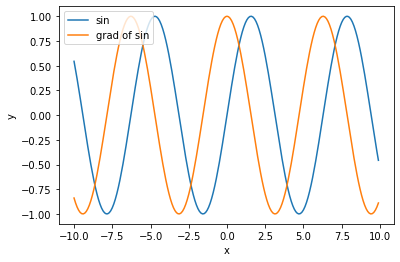

In [75]:
#1.计算二阶导数是在一阶导数的基础上再求导数
#2.会发生梯度的累积
#3.d变成一个向量，只有传入梯度为1的参数才能利用反向传播函数求梯度
#4.控制流求梯度
'''def f1(x1):
  y1 = x1 ** 2
  y2 = x1 ** 3
  if x1 > 0:
    return y1
  else:
    return y2

x_1 = torch.randn(size=(),requires_grad=True)
y_1 = f1(x_1)
y_1.backward()
x_1.grad'''
#5python绘制函数图象

import matplotlib.pyplot as plt
import torch

x = torch.arange(-10, 10, 0.1)
x.requires_grad_(True)
#x1 = torch.tensor(x, requires_grad=True)
x1 = x.detach()#将x分离计算为x1
y1 = torch.sin(x1)
y = torch.sin(x)
y.sum().backward()

plt.plot(x1,y1,label="sin")
plt.plot(x1,x.grad,label="grad of sin")
plt.legend(loc = 2)
plt.xlabel("x")
plt.ylabel("y")

plt.show()

[Discussions](https://discuss.d2l.ai/t/1759)
